# Import Librarys and Files

## Imports

### Add top level to the import path

In [1]:
import sys
import os

# Add the project root to sys.path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

### Import some classes/modules we'll be using

In [20]:
import ROOT as r
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from importlib import reload
from tqdm.notebook import tqdm 
from datetime import datetime


import utils.utils as utils
import utils.plotting_utils as plotting_utils
from models.event_patterns import EventPatterns
from models.pattern import Pattern
from models.vertex import Vertex
from models.tracklet import Tracklet
from models.hit import Hit

## Load Shared libraries to access methods of ROOT objects in python

In [3]:
PI_ROOT_DICT_PATH = "/home/jack/large_projects/simulation/install/lib/libPiRootDict.so" #Change to match system path
r.gSystem.Load(PI_ROOT_DICT_PATH)

0

## Load Pattern finding truth data
This also contains what we need to reconstruct patterns. So it gives validation (true patterns) and a method to create our own pattern

In [4]:
data_dir = "/home/jack/large_projects/simulation/workspace/playground/reco_algorithm_tests/data/" #CHANGE THIS
file_truth_pattern_finding = "all_rec_pimunu_truth.root" #CHANGE THIS

# Combine directory and file name
file_truth_pattern_finding_path = os.path.join(data_dir, file_truth_pattern_finding)

# Print creation time for the full file path
utils.print_file_creation_time(file_truth_pattern_finding_path)

# Open the file
file_truth_pf = r.TFile(file_truth_pattern_finding_path, "READ")


The file '/home/jack/large_projects/simulation/workspace/playground/reco_tests/all_rec_pimunu_truth.root' was created on: 2025-04-07 00:54:16


## Get ROOT objects from our file
Making these more than once can cause memory leaks

In [5]:
tree = file_truth_pf.Get("rec")
geoHelper = file_truth_pf.Get("PIMCGeoHelper")

## Initialize Event Patterns Object

In [6]:
# Initialize Event patterns without tracklet, vertex, and pattern forming algorithms (we'll add them later)
event_index = 0
event_patterns = EventPatterns(event_index, None, None, None, validator = None)

# For "normal use" you'd just initialize with all 3 pattern forming algorithms here, then call event_patterns.form_all(file, index)
# Below, we go through each step instead:


## Create tracklets for an event

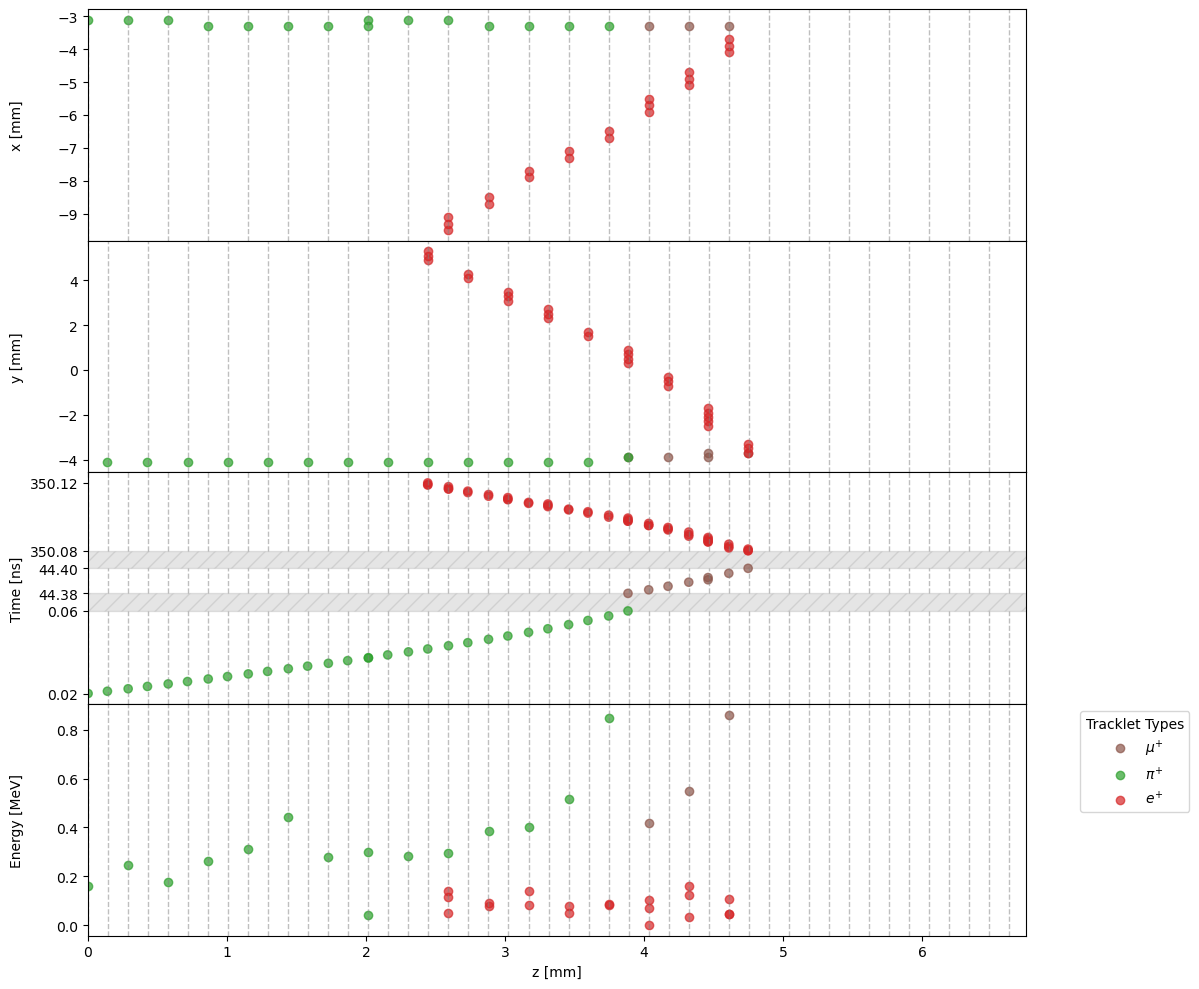

Extra event info:
{'stage': <Stage.TRACKLETS_FORMED: 1>, 'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -11: 1, -13: 1}), 'patterns_truth': {0: [0, 1, 2]}}}


In [7]:
# Choose a tracklet forming algorithm, I'm use this default one, but you can write your own child class of TrackletFormer
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
event_patterns.tracklet_former = DefaultTrackletFormer()
event_patterns.form_tracklets(tree, geoHelper, event_index)

# Plot the tracklets
reload(plotting_utils)
plotting_utils.plot_event(event_patterns)

# See the extra info stored at this point
print("Extra event info:")
print(event_patterns.extra_info)

## Create Vertices from Tracklets

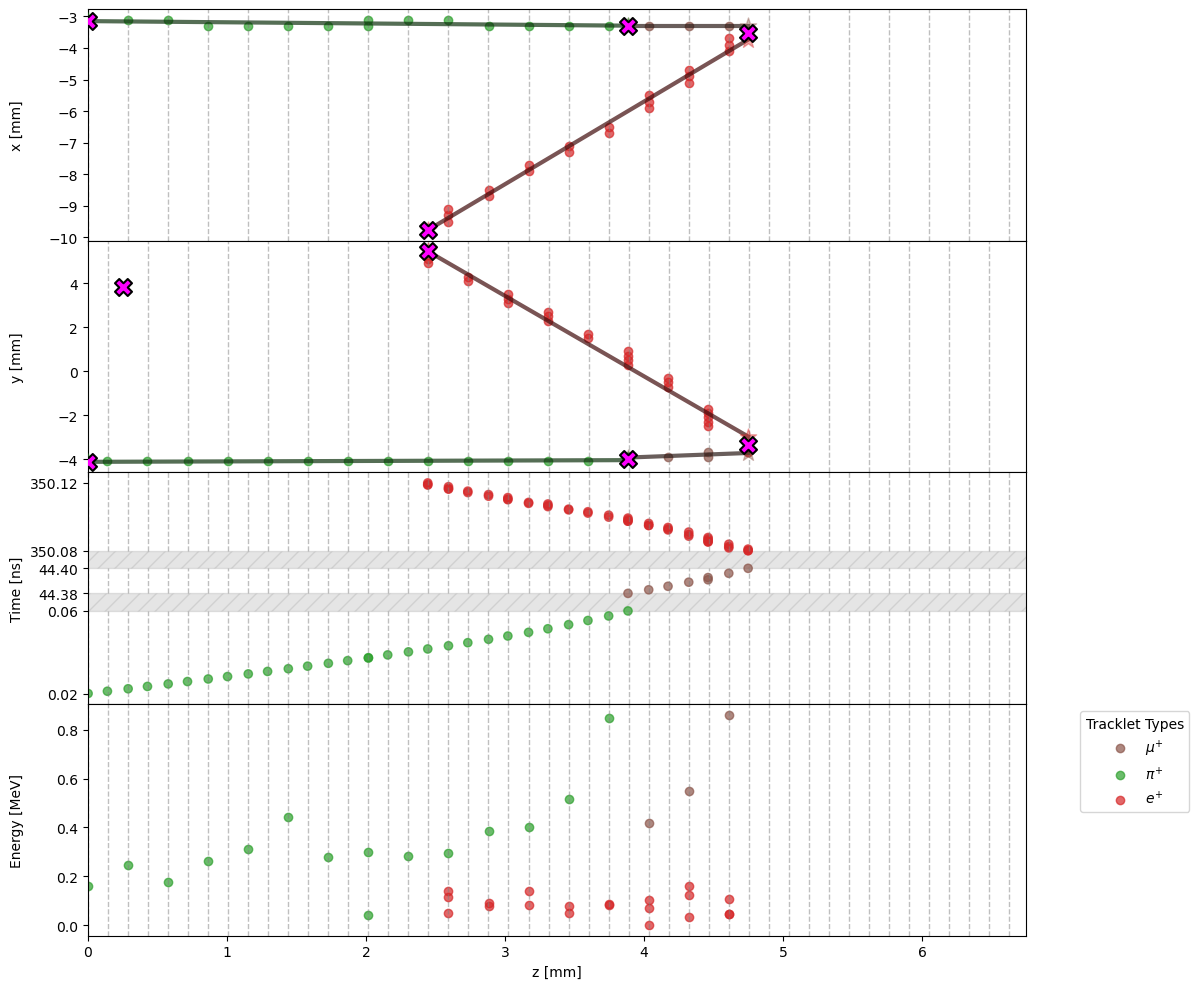

Extra event info:
{'stage': <Stage.VERTICES_FORMED: 2>, 'tracklet_algorithm_info': {'n_patterns_truth': 1, 'particles_in_event_truth': Counter({211: 1, -11: 1, -13: 1}), 'patterns_truth': {0: [0, 1, 2]}}, 'vertex_algorithm_info': {'vertex_comparison': {'front_vertices': {Vertex(id=3, num_tracklets=2), Vertex(id=0, num_tracklets=2), Vertex(id=2, num_tracklets=1), Vertex(id=1, num_tracklets=1)}, 'back_vertices': {Vertex(id=4, num_tracklets=2), Vertex(id=2, num_tracklets=2), Vertex(id=0, num_tracklets=1), Vertex(id=3, num_tracklets=1)}, 'match': True}, 'stats': {'front': {'BIC': 17.06337728699699, 'k': 4, 'centroids': array([[-3.51820971e+00,  0.00000000e+00,  4.74749977e+00],
       [-3.14999992e+00,  0.00000000e+00,  5.00000715e-04],
       [-9.77153052e+00,  0.00000000e+00,  2.44350011e+00],
       [-3.29722837e+00,  0.00000000e+00,  3.88349993e+00]])}, 'back': {'BIC': 20.553793700539778, 'k': 5, 'centroids': array([[ 0.00000000e+00,  5.45547879e+00,  2.44350011e+00],
       [ 0.000000

In [8]:
# Choose a vertex forming algorithm, I'm using this kmeans one, but you can write your own child class of VertexFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
event_patterns.vertex_former = KMeansVertexFormer()

event_patterns.form_vertices()

reload(plotting_utils)
plotting_utils.plot_event(event_patterns)

# See the extra info stored at this point
print("Extra event info:")
print(event_patterns.extra_info)

## Create Patterns from Vertices

In [9]:
# Choose a pattern forming algorithm, I'm using this default one, but you can write your own child class of PatternFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
event_patterns.pattern_former = DefaultPatternFormer()
event_patterns.form_patterns()

# Print patterns and the unique tracklets within each pattern along with vertex information
patterns = event_patterns.get_patterns()
for pattern in patterns:
    print(f"\nPattern with {len(pattern.get_vertices())} vertices.")

    # Print info for each vertex in the pattern
    for vertex in pattern.get_vertices():
        tracklet_ids = [t.tracklet_id for t in vertex.get_tracklets()]
        print(f"  Vertex {vertex.vertex_id} (tracklet_ids={tracklet_ids})")

    print("  Unique Tracklets:")
    unique_tracklets = pattern.get_unique_tracklets()
    for tracklet in unique_tracklets:
        print(f"    {tracklet}")


# See the extra info stored at this point
print()
print("Extra event info:")
print(event_patterns.extra_info)


Pattern with 4 vertices.
  Vertex 3 (tracklet_ids=[2, 0])
  Vertex 0 (tracklet_ids=[2, 1])
  Vertex 2 (tracklet_ids=[1])
  Vertex 1 (tracklet_ids=[0])
  Unique Tracklets:
    Tracklet(id=2, particle_id=-13, name=\mu^{+}, color=#8C564B, e_id=3162, hits=8, extra_info_keys=['fit_results'], endpoints=(Point3D(x=-3.2999999523162837, y=-3.9307693481680204, z=3.883499927520752), Point3D(x=-3.2999999523162833, y=-3.72307703504434, z=4.747499771118164)))
    Tracklet(id=1, particle_id=-11, name=e^{+}, color=#D62728, e_id=3162, hits=48, extra_info_keys=['fit_results'], endpoints=(Point3D(x=-9.771530517184479, y=5.455478794652807, z=2.443500108718872), Point3D(x=-3.736419473379632, y=-2.9742521576742504, z=4.747499771118164)))
    Tracklet(id=0, particle_id=211, name=\pi^{+}, color=#2CA02C, e_id=3162, hits=29, extra_info_keys=['fit_results'], endpoints=(Point3D(x=-3.149999917660699, y=-4.12561495801517, z=0.000500000715255744), Point3D(x=-3.294456794660987, y=-4.04857138559526, z=3.8834999275207

## (Optional) Validate Event Against Truth
This requires some truth information to be stored in the pattern's "extra_info". In this case, we stored it in the tracklet forming stage

In [10]:
# Choose a validation algorithm, I'm using one that checks that each pattern in the reco and truth contain the same tracklet ids
# but you can write your own child class of EventValidator
from algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator
event_patterns.validator = TrackletGroupingValidator(verbose = 1)
event_patterns.validate()


[Validation Success] All patterns validated successfully.


True

# Reconstruct Multiple Events

## Make cuts on the data set

In [11]:
# Number of events to process (set to None or a large number to process all events)
MAX_EVENTS = None
N_EVENTS = tree.GetEntries() if MAX_EVENTS is None else min(MAX_EVENTS, tree_pf.GetEntries())

use_pitar = True
use_in_fid_vol = True

nentries = tree.GetEntries()
all_events = []  # Store event IDs of all events that pass the initial cuts

for iEntry in tqdm(range(min(nentries, N_EVENTS)), desc="Processing Events"):

    patternFailed = False
    tree.GetEntry(iEntry)

    # SELECTIONS
    pitar = any(info.Has(r.kPitar) for info in tree.infoVec)

    if (not pitar) and use_pitar:
        continue

    in_fid_vol = True
    for tracklet in tree.trackletVec:
        for hit in tracklet.GetAllHits():
            vname = geoHelper.GetVolumeName(hit.GetVID()).Data()
            if 'atar' in vname:
                side = vname[11]
                if (side == "f" and abs(geoHelper.GetX(hit.GetVID())) > 8) or \
                   (side == "b" and abs(geoHelper.GetY(hit.GetVID())) > 8):
                    in_fid_vol = False

    if (not in_fid_vol) and use_in_fid_vol:
        continue

    all_events.append(iEntry)

Processing Events:   0%|          | 0/28259 [00:00<?, ?it/s]

## Run Reconstruction on Events

In [12]:
from algorithms.tracklet.default_tracklet_former import DefaultTrackletFormer
from algorithms.vertex.kmeans_vertex_former import KMeansVertexFormer
from algorithms.pattern.default_pattern_former import DefaultPatternFormer
from algorithms.validation.tracklet_grouping_validator import TrackletGroupingValidator

# Preallocate array
reconstructed_events = np.empty(len(all_events), dtype=object)

# tqdm with simple progress description
with tqdm(total=len(all_events), desc="Reconstructing events") as pbar:
    for i, event_index in enumerate(all_events):
        event_patterns = EventPatterns(event_index, DefaultTrackletFormer(), KMeansVertexFormer(), DefaultPatternFormer(), TrackletGroupingValidator())
        event_patterns.form_all(tree, geoHelper, event_index)
        reconstructed_events[i] = event_patterns
        pbar.update(1)


Reconstructing events:   0%|          | 0/17176 [00:00<?, ?it/s]

# Check/View Algorithm Performance

## Performance vs. Particle composition

### Performance categorized by reconstructed particle componsition
Sometimes tracklets exist in truth, but do not create a hit in the atar. As a result, we cannot always construct the true particle composition.

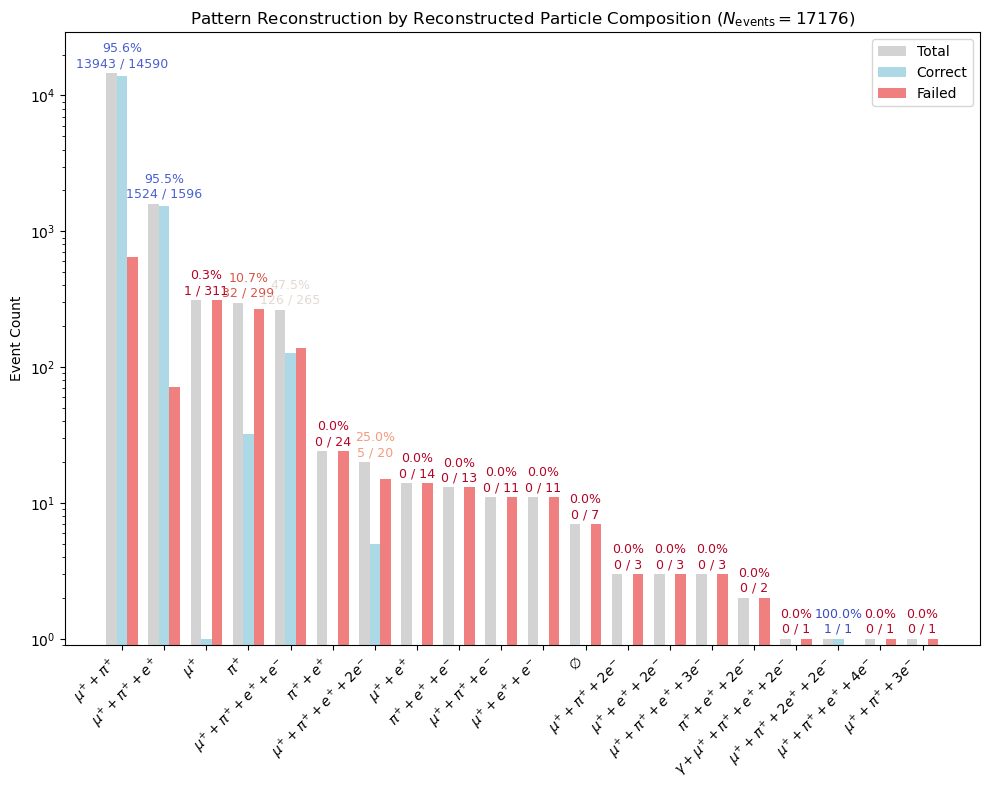

In [13]:
reload(plotting_utils)
title = f"Pattern Reconstruction by Reconstructed Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = False, title =  title)

### Performance categorized by true particle componsition
We can tag each event with the true particle composition information and plot against that instead to also see performance based on true particle composition

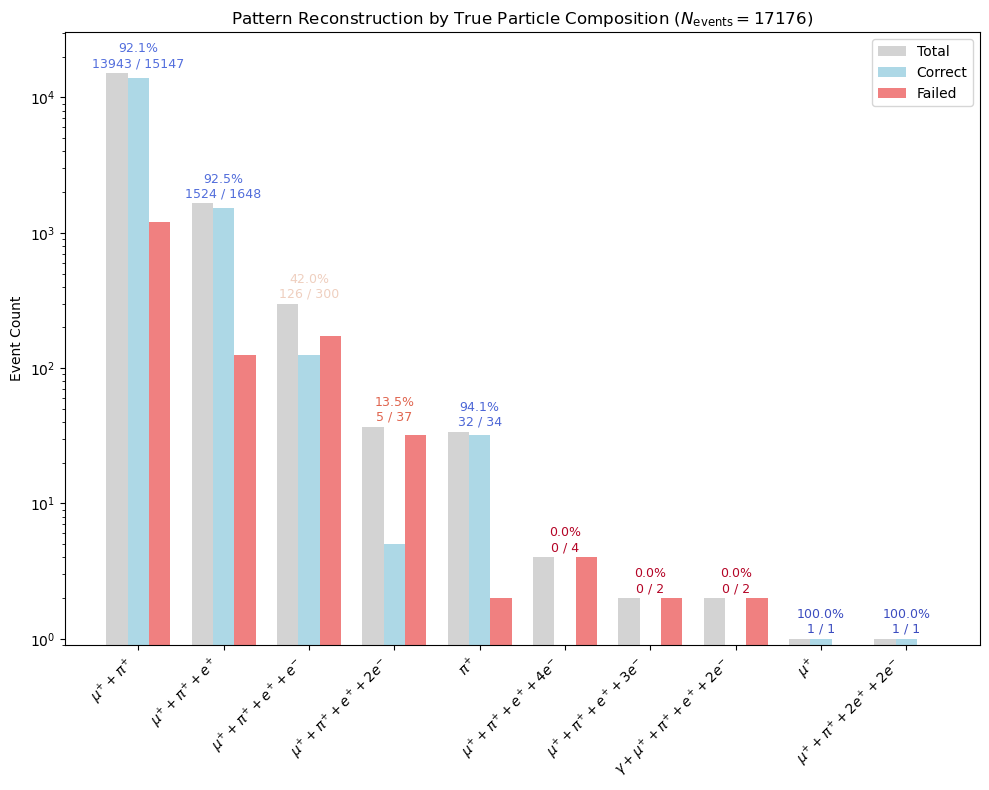

In [14]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_classification_from_patterns(reconstructed_events, use_truth_particles = True, title =  title)

## Performance vs. True Number of Patterns

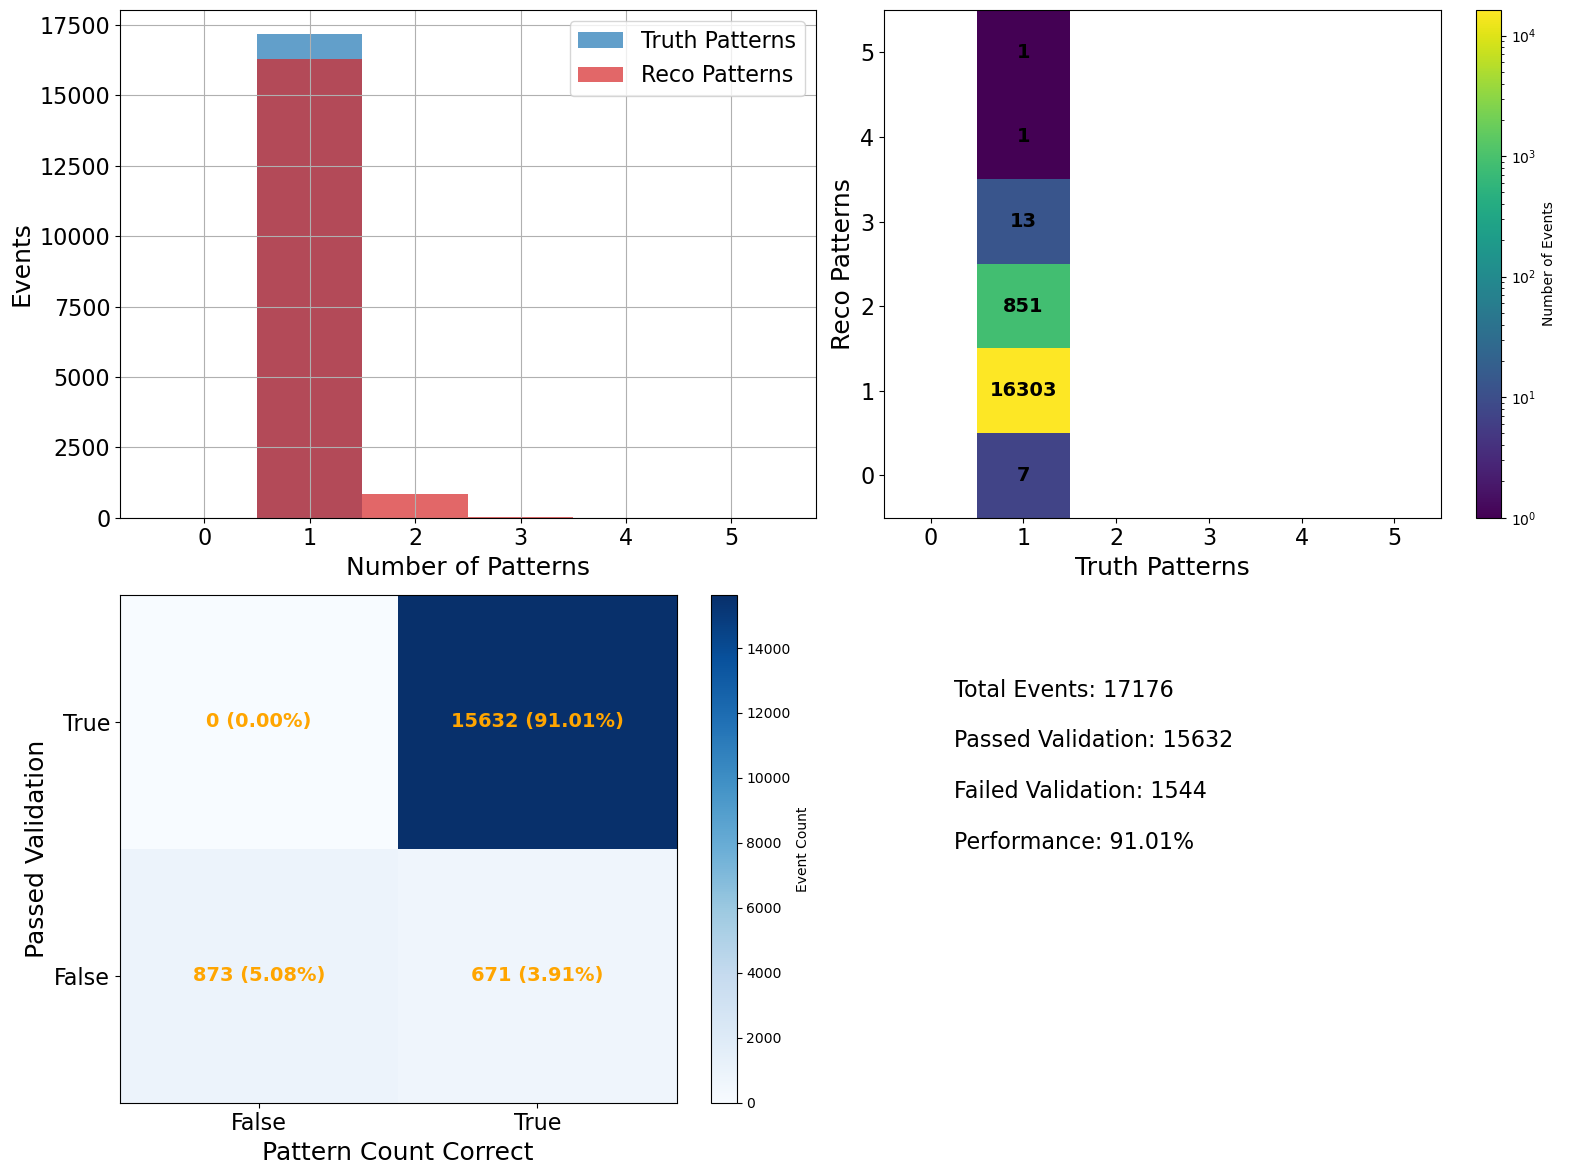

In [15]:
reload(plotting_utils)
title = f"Pattern Reconstruction by True Particle Composition ($N_{{\\text{{events}}}} = {len(reconstructed_events)}$)"
plotting_utils.plot_event_patterns_summary(reconstructed_events, title =  None)

## Performance vs. Using front/back Vertex
The kmeans algorithm is applies to the "front" planes or (x,z) coordinates and the "back" planes or (y,z) coordinates. Sometimes, they can group tracklets into vertices differently.

### Performance vs. Front/back Vertices agreement


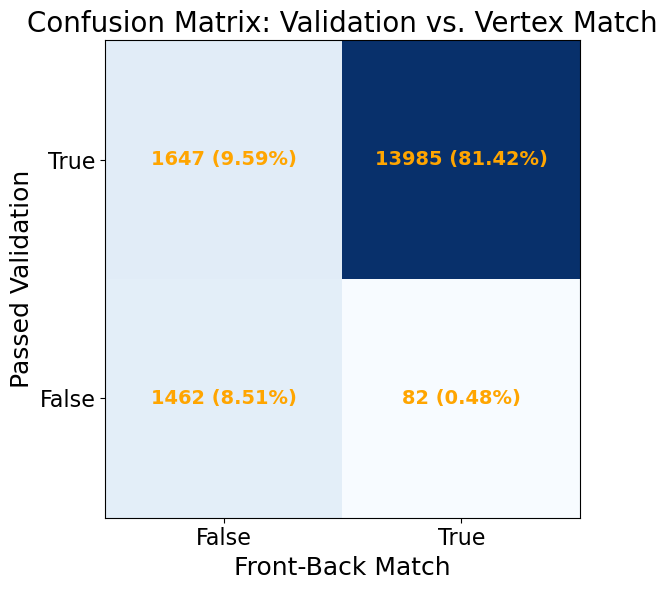

In [16]:
reload(plotting_utils)

# Extract metrics
vertex_match = []
validation_passed = []

for ep in reconstructed_events:
    vertex_info = ep.extra_info.get("vertex_algorithm_info", {})
    match = vertex_info.get("vertex_comparison", {}).get("match", False)
    validated = ep.validate()

    vertex_match.append(match)
    validation_passed.append(validated)

    if validated and not match:
        patterns_truth = ep.extra_info.get("tracklet_algorithm_info", {}).get("patterns_truth", {})
        reconstructed_tracklet_ids = sorted([
            t.tracklet_id
            for pattern in ep.get_patterns()
            for t in pattern.get_unique_tracklets()
        ])

# Plot confusion matrix (swapped axes)
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix, im = plotting_utils.plot_confusion_matrix(
    ax,
    metric1=validation_passed,         # now on Y axis
    metric2=vertex_match,              # now on X axis
    total=len(reconstructed_events),
    x_axis_label="Front-Back Match",
    y_axis_label="Passed Validation"
)
plt.title("Confusion Matrix: Validation vs. Vertex Match", fontsize=20)
plt.tight_layout()
plt.show()


### Performance vs. Front/Back Vertices (validated using each)

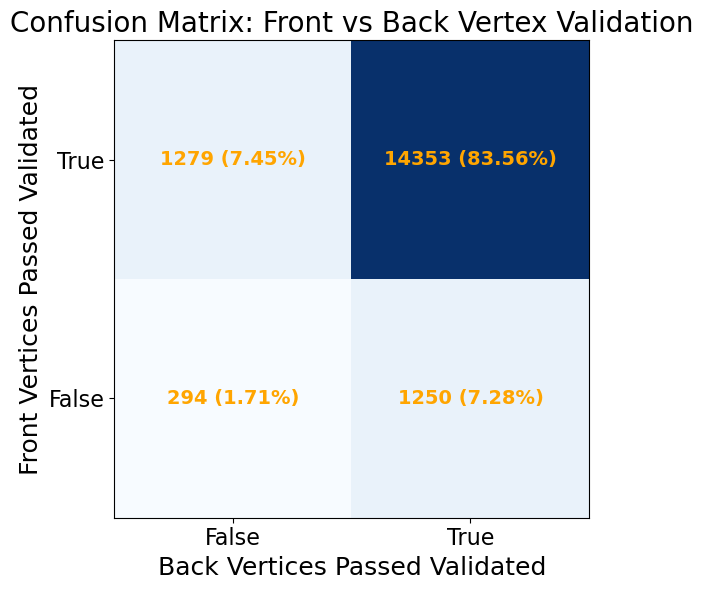

In [19]:
reload(plotting_utils)

# Collect validation results
validation_front = []
validation_back = []

for ep in reconstructed_events:
    # Step 1: Temporarily use back vertices for validation
    back_vertices = ep.extra_info.get("vertex_algorithm_info", {}).get("vertex_comparison", {}).get("back_vertices", set())
    ep.patterns = {Pattern(0, back_vertices)}
    ep.form_patterns()
    validated_back = ep.validate()
    validation_back.append(validated_back)

    # Step 2: Use front vertices for validation
    front_vertices = ep.extra_info.get("vertex_algorithm_info", {}).get("vertex_comparison", {}).get("front_vertices", set())
    ep.patterns = {Pattern(0, front_vertices)}
    ep.form_patterns()
    validated_front = ep.validate()
    validation_front.append(validated_front)

# Plot confusion matrix: front vs back validation
fig, ax = plt.subplots(figsize=(6, 6))
conf_matrix, im = plotting_utils.plot_confusion_matrix(
    ax,
    metric1=validation_front,     # Y-axis
    metric2=validation_back,      # X-axis
    total=len(reconstructed_events),
    x_axis_label="Back Vertices Passed Validated",
    y_axis_label="Front Vertices Passed Validated"
)
plt.title("Confusion Matrix: Front vs Back Vertex Validation", fontsize=20)
plt.tight_layout()
plt.show()


## Performance vs choice of sigma and n_iters parameters

### Gather data by varying parameters
This will likely take a while, depending on how big your data set and scan are

In [27]:
# Parameters for sigma and n_iters to test
sigma_values = [0.1, 0.5, 1, 5, 10]  # Updated sigma values
n_iters_values = [1, 3, 5, 10, 25]  # Updated n_iters values

# Validation results storage (for heatmap)
validation_results = []

# Create a timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define the output file name with the timestamp
output_file_name = f"validation_results_{timestamp}.csv"

# Combine the data directory with the output file name
output_file_path = os.path.join(data_dir, output_file_name)

# tqdm with simple progress description
total_events = len(all_events)
total_combinations = total_events * len(sigma_values) * len(n_iters_values)

with tqdm(total=total_combinations, desc="Reconstructing events") as pbar:
    for event_index in all_events:
        for sigma in sigma_values:
            for n_iters in n_iters_values:
                kmeans_vertex_former = KMeansVertexFormer(n_iters=n_iters, sigma=sigma)
                event_patterns = EventPatterns(
                    event_index,
                    DefaultTrackletFormer(),
                    kmeans_vertex_former,
                    DefaultPatternFormer(),
                    TrackletGroupingValidator()
                )
                event_patterns.form_all(tree, geoHelper, event_index)
                validated = event_patterns.validate()
                validation_results.append([event_index, sigma, n_iters, validated])
                pbar.set_postfix({"Event": event_index, "Validated": validated, "Sigma": sigma, "N_Iters": n_iters})
                pbar.update(1)

# Save final results
validation_df = pd.DataFrame(validation_results, columns=["Event_Index", "Sigma", "N_Iters", "Validated"])
validation_df.to_csv(output_file_path, index=False)


Reconstructing events:   0%|          | 0/429400 [00:00<?, ?it/s]

### Average validation over events

In [34]:
# Get all unique sigma and n_iters combinations
unique_combinations = validation_df[["Sigma", "N_Iters"]].drop_duplicates().values

# Initialize a list to store averaged results with uncertainty
averaged_results = []

# Loop over combinations
for sigma, n_iters in unique_combinations:
    subset = validation_df[
        (validation_df["Sigma"] == sigma) & (validation_df["N_Iters"] == n_iters)
    ]
    count = len(subset)
    p = subset["Validated"].mean()
    uncertainty = (p * (1 - p))**0.5 / count**0.5 if count > 0 else 0

    averaged_results.append([sigma, n_iters, p, uncertainty])

# Create a DataFrame from the averaged results
average_df = pd.DataFrame(averaged_results, columns=["Sigma", "N_Iters", "Average_Validated", "Uncertainty"])



### Plot results

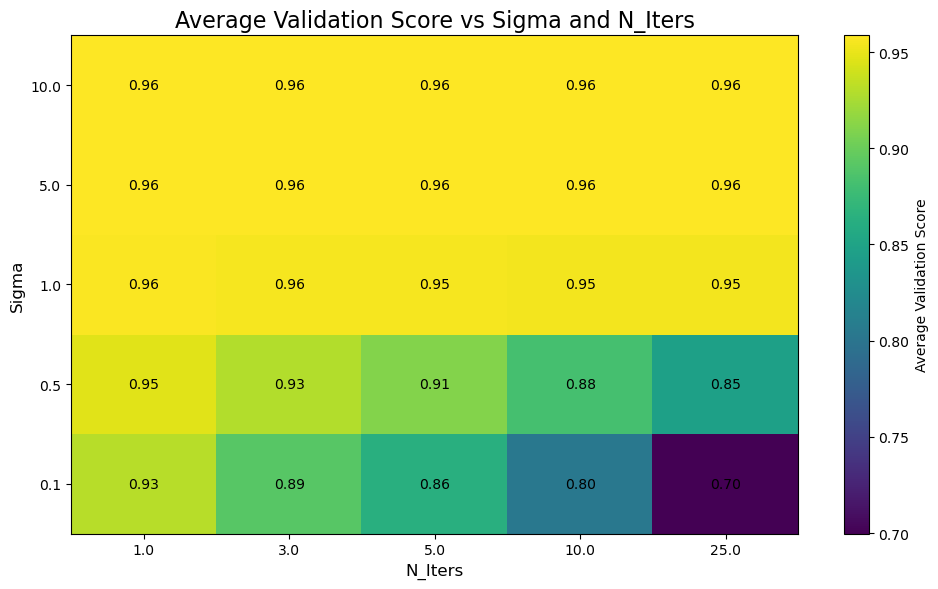

In [35]:
# Pivot for heatmap plotting
validation_pivot = average_df.pivot(index="Sigma", columns="N_Iters", values="Average_Validated")

# Convert pivot table to a NumPy array for imshow
heatmap_data = validation_pivot.values
x_labels = validation_pivot.columns.tolist()
y_labels = validation_pivot.index.tolist()

# Plot the heatmap using matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(heatmap_data, cmap="viridis", aspect="auto", origin="lower")

# Show values in each cell
for i in range(len(y_labels)):
    for j in range(len(x_labels)):
        value = heatmap_data[i, j]
        ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="white" if value < 0.5 else "black")

# Set ticks and labels
ax.set_xticks(np.arange(len(x_labels)))
ax.set_yticks(np.arange(len(y_labels)))
ax.set_xticklabels(x_labels)
ax.set_yticklabels(y_labels)

# Axis labels and title
ax.set_xlabel("N_Iters", fontsize=12)
ax.set_ylabel("Sigma", fontsize=12)
ax.set_title("Average Validation Score vs Sigma and N_Iters", fontsize=16)

# Colorbar
fig.colorbar(cax, label="Average Validation Score")

plt.tight_layout()
plt.show()
